# Setup & json EDA

In [108]:
import json
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#Specify the path to your JSON file
file_path = '../Stanford/json_files/89-TM-1249-1570526874501-1.json'

# Load the JSON data from the file
with open(file_path, 'r') as file:
    json_data = json.load(file)

# Extract the 'points' data
points_data = json_data['lines'][0]['points']

# Convert to a DataFrame
data = pd.DataFrame(points_data)

data.head()


,altitude_angle,azimuth_angle,force,sequence_number,timestamp,x,y
0,0.834041,1.243064,0.333333,0,199262.408,682.500000,687.307129
1,0.834041,1.243064,0.333333,1,199262.412,682.562500,686.973633
2,0.834041,1.243064,0.333333,2,199262.416,682.765625,686.577576
3,0.834041,1.243064,0.333333,3,199262.420,682.890625,686.244080
4,0.834041,1.243064,0.333333,4,199262.425,683.031250,685.910583


In [109]:
data.describe()

,altitude_angle,azimuth_angle,force,sequence_number,timestamp,x,y
count,1431.000000,1431.000000,1431.000000,1431.00000,1431.000000,1431.000000,1431.000000
mean,0.931039,0.775692,1.620442,715.00000,199265.388781,467.975542,802.477111
std,0.117801,0.288178,0.401120,413.23843,1.722828,65.291448,34.857323
min,0.827510,0.180411,0.000000,0.00000,199262.408000,430.359375,681.137451
25%,0.834041,0.569457,1.504018,357.50000,199263.898000,438.718750,804.906158
50%,0.876552,0.847739,1.697268,715.00000,199265.389000,445.156250,814.702606
75%,1.033099,0.968970,1.869027,1072.50000,199266.879000,452.687500,820.913971
max,1.165096,1.243064,2.318379,1430.00000,199268.370000,690.859375,825.499542


# Data/Feature Extration

### Description of Extracted Features

#### **Temporal Features**
1. **total_time**: Total time taken to complete the task (max timestamp - min timestamp).
2. **avg_time_interval**: Average time interval between consecutive points.



#### **Spatial Features**
3. **total_distance**: Total path length (sum of Euclidean distances between points).
4. **avg_speed**: Average drawing speed (total distance / total time).



#### **Path Shape Features**
5. **avg_curvature**: Average curvature of the path (mean angle changes). 
6. **max_curvature**: Maximum curvature observed. --NEW FEATURE---



#### **Force Features**
7. **avg_force**: Mean force applied during the task.
8. **force_std**: Variability in force (standard deviation). --NEW FEATURE---



#### **Error Features**
9. **pen_lift_count**: Total number of pen lifts (pauses > 0.1s). --NEW FEATURE---
10. **avg_lift_duration**: Average duration of pen lifts. --NEW FEATURE---

### **Altitude and Azimuth Angle Features**
11. **std_altitude_angle**: Standard deviation of the altitude angle (measures variability in stylus tilt). --NEW FEATURE---
12. **std_azimuth_angle**: Standard deviation of the azimuth angle (measures variability in stylus direction). --NEW FEATURE---




These features capture temporal, spatial, force, error characteristics and stylus angles for analysis and classification.


In [110]:


# Function to calculate curvature between three points
def calculate_curvature(p1, p2, p3):
    angle1 = np.arctan2(p2['y'] - p1['y'], p2['x'] - p1['x'])
    angle2 = np.arctan2(p3['y'] - p2['y'], p3['x'] - p2['x'])
    return abs(angle2 - angle1)

# Feature extraction function
def extract_features_from_test(test_data, file_name):
    features = {}
    lines = test_data['lines']
    timestamps = [point['timestamp'] for line in lines for point in line['points']]
    features['total_time'] = max(timestamps) - min(timestamps)
    features['avg_time_interval'] = np.mean(np.diff(sorted(timestamps)))

    points = [point for line in lines for point in line['points']]
    x_coords = [p['x'] for p in points]
    y_coords = [p['y'] for p in points]
    distances = [np.sqrt((x_coords[i+1] - x_coords[i])**2 + (y_coords[i+1] - y_coords[i])**2)
                 for i in range(len(x_coords)-1)]
    features['total_distance'] = sum(distances)
    features['avg_speed'] = features['total_distance'] / features['total_time']

    curvatures = [
        calculate_curvature(points[i-1], points[i], points[i+1])
        for i in range(1, len(points)-1)
    ]
    features['avg_curvature'] = np.mean(curvatures)
    features['max_curvature'] = max(curvatures)

    forces = [p['force'] for p in points]
    features['avg_force'] = np.mean(forces)
    features['force_std'] = np.std(forces)

    lift_durations = [timestamps[i+1] - timestamps[i] for i in range(len(timestamps)-1) if timestamps[i+1] - timestamps[i] > 0.1]
    features['pen_lift_count'] = len(lift_durations)
    features['avg_lift_duration'] = np.mean(lift_durations) if lift_durations else 0

    # Altitude and Azimuth Angle Features
    altitude_angles = [p['altitude_angle'] for p in points]
    azimuth_angles = [p['azimuth_angle'] for p in points]
    features['std_altitude_angle'] = np.std(altitude_angles)
    features['std_azimuth_angle'] = np.std(azimuth_angles)

    
    # Include the file name without suffix in the features
    features['file_name'] = os.path.splitext(file_name)[0]
    return features


def process_json_files(file_paths):
    feature_list = []
    testclass = None
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            json_data = json.load(f)
            file_name = os.path.basename(file_path)  # Extract just the file name
            testclass = 0 if file_name.endswith('1.json') else 1
            features = extract_features_from_test(json_data, file_name)
            features['test_class'] = testclass
            feature_list.append(features)


    return pd.DataFrame(feature_list)

# Example Usage
stanford_dir = '../Stanford/json_files'  # Replace with the actual directory path
file_paths = [os.path.join(stanford_dir, file) for file in os.listdir(stanford_dir) if file.endswith('.json')]

# Process all the JSON files and include file names
feature_df = process_json_files(file_paths)


feature_df.sort_values(by=['test_class', 'file_name'], inplace=True)

feature_df.reset_index(drop=True, inplace=True)

feature_df.head()


,total_time,avg_time_interval,total_distance,avg_speed,avg_curvature,max_curvature,avg_force,force_std,pen_lift_count,avg_lift_duration,std_altitude_angle,std_azimuth_angle,file_name,test_class
0,54.216,0.004826,8618.839643,158.972253,0.383612,6.257713,1.832864,0.708911,4,1.8500,0.289156,0.553115,20-TM-290-1567591168549-1,0
1,44.169,0.004240,7609.544827,172.282479,0.256161,6.262246,2.516199,0.806036,1,0.7470,0.215208,0.253108,21-TM-274-1567588789383-1,0
2,47.333,0.004169,8640.305545,182.542952,0.314816,6.269712,0.990758,0.229715,0,0.0000,0.169155,0.459101,28-TM-395-1568108355087-1,0
3,25.124,0.004169,8372.079312,333.230350,0.156462,6.283185,1.082974,0.325447,0,0.0000,0.074196,0.162551,32-TM-444-1568282376602-1,0
4,56.905,0.004613,9042.131215,158.898712,0.303942,6.283185,1.621549,0.465386,4,1.3725,0.179172,0.211929,33-TM-458-1568287646230-1,0


# Exploratory Data Analysis

Using test class 0 for TNT-A and 1 for TNT-B

In [111]:
feature_df.drop(columns=['file_name'], inplace=True)

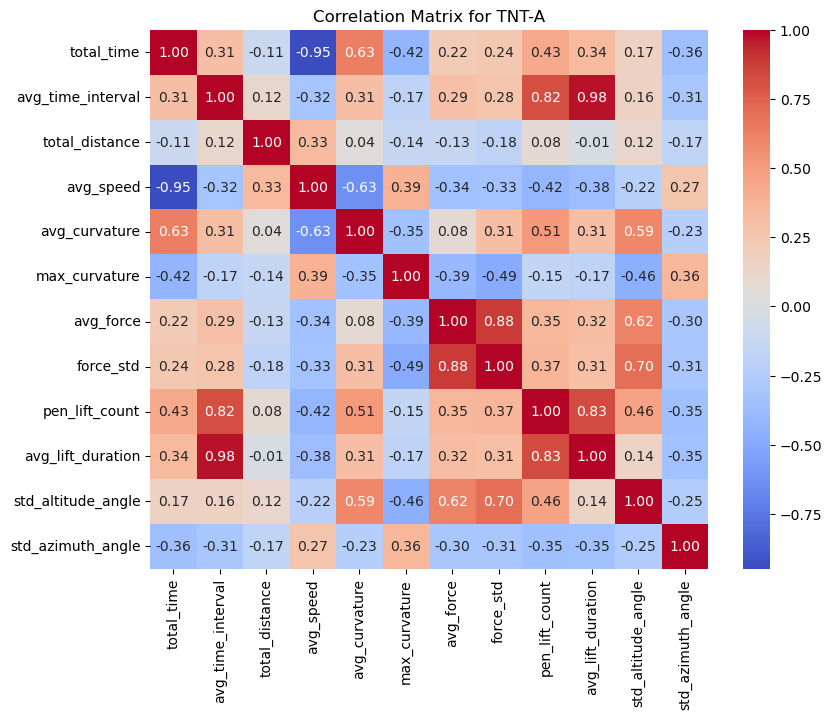

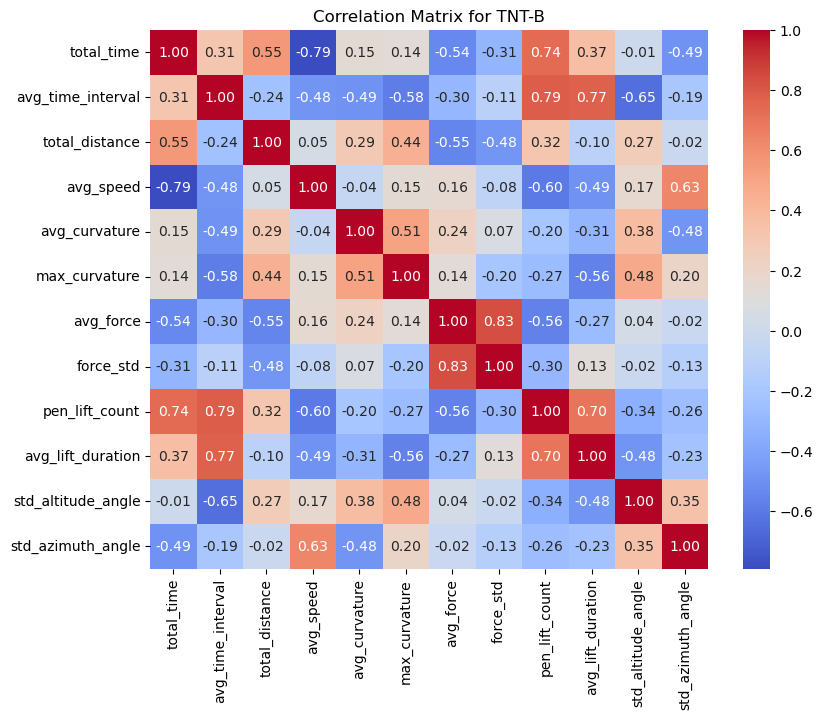

In [112]:



#correlation matrix
correlation_matrix = feature_df[feature_df['test_class'] != 1].drop(columns=['test_class']).corr()


plt.figure(figsize=(9, 7))
plt.title('Correlation Matrix for TNT-A')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#correlation matrix
correlation_matrix = feature_df[feature_df['test_class'] != 0].drop(columns=['test_class']).corr()


plt.figure(figsize=(9, 7))
plt.title('Correlation Matrix for TNT-B')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()




<Figure size 2000x2000 with 0 Axes>

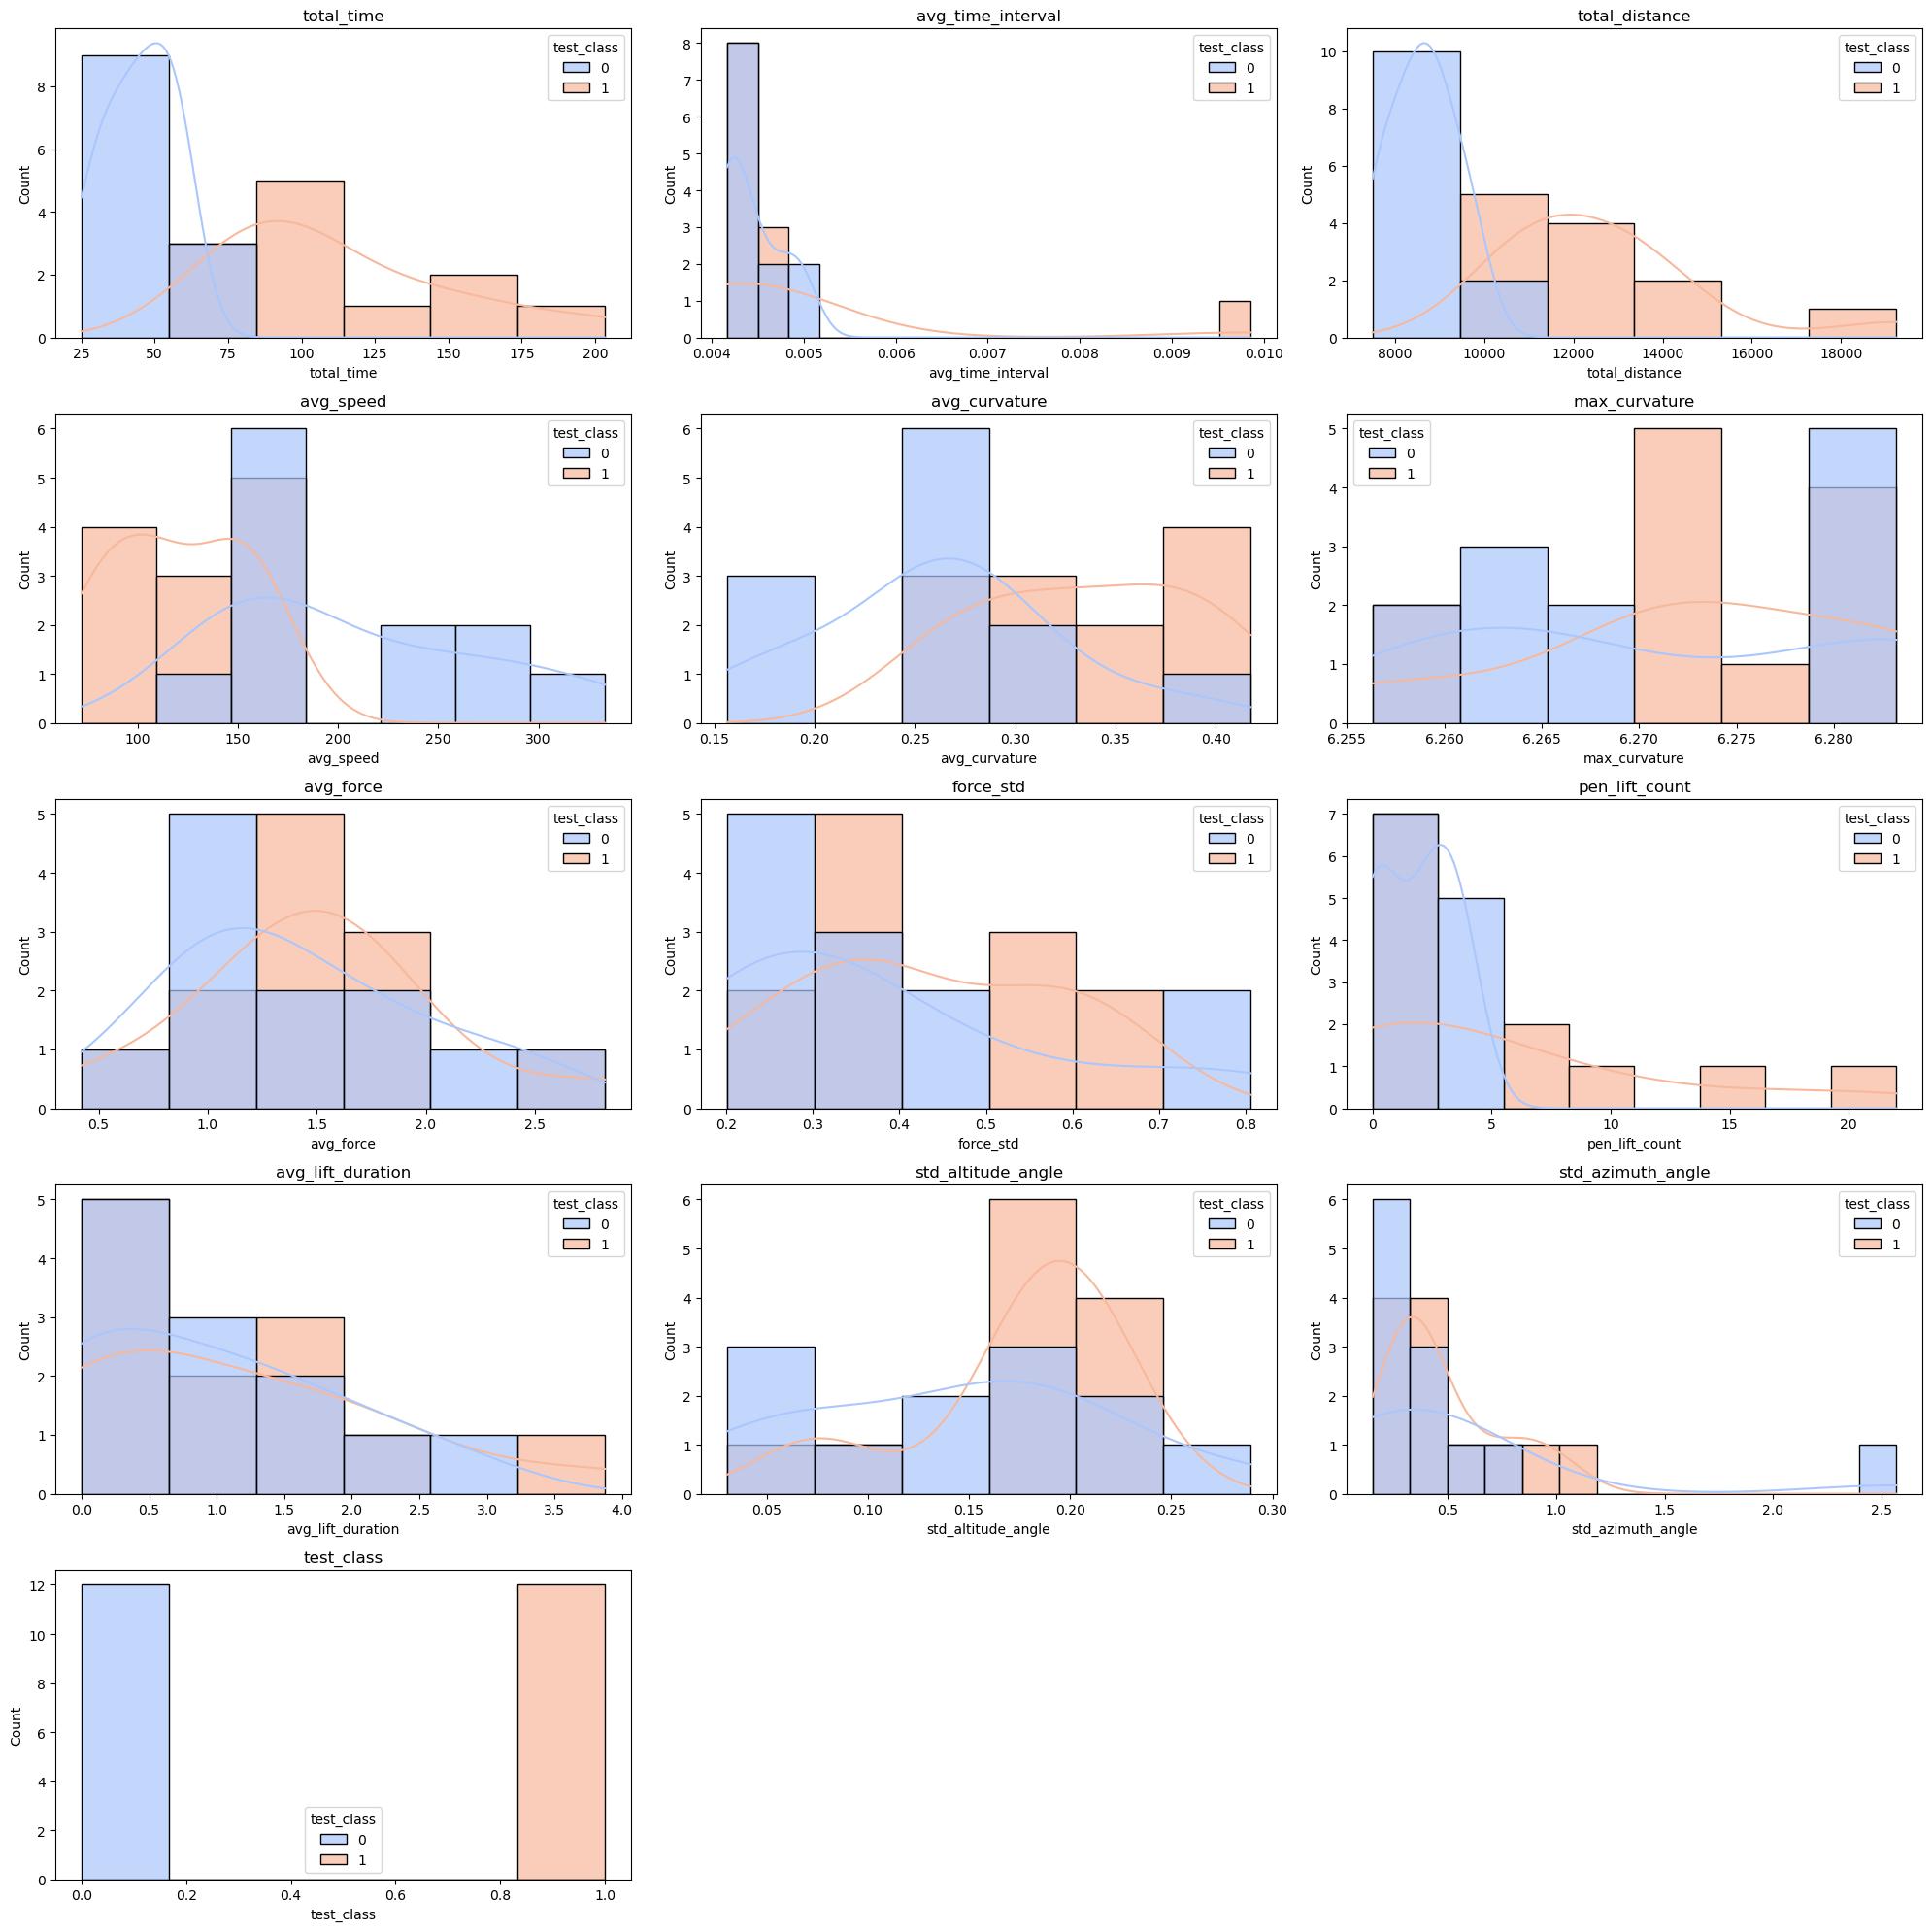

In [113]:
# Set the figure size
plt.figure(figsize=(20, 20))

plt.figure(figsize=(20, 20))  # Set the figure size

for i, column in enumerate(feature_df.columns, 1):
    plt.subplot((len(feature_df.columns) // 3) + 1, 3, i)  # Adjust subplot grid size
    sns.histplot(data=feature_df, x=column, hue='test_class', kde=True, palette='coolwarm', alpha=0.7)
    plt.title(column)

plt.tight_layout()
plt.show()

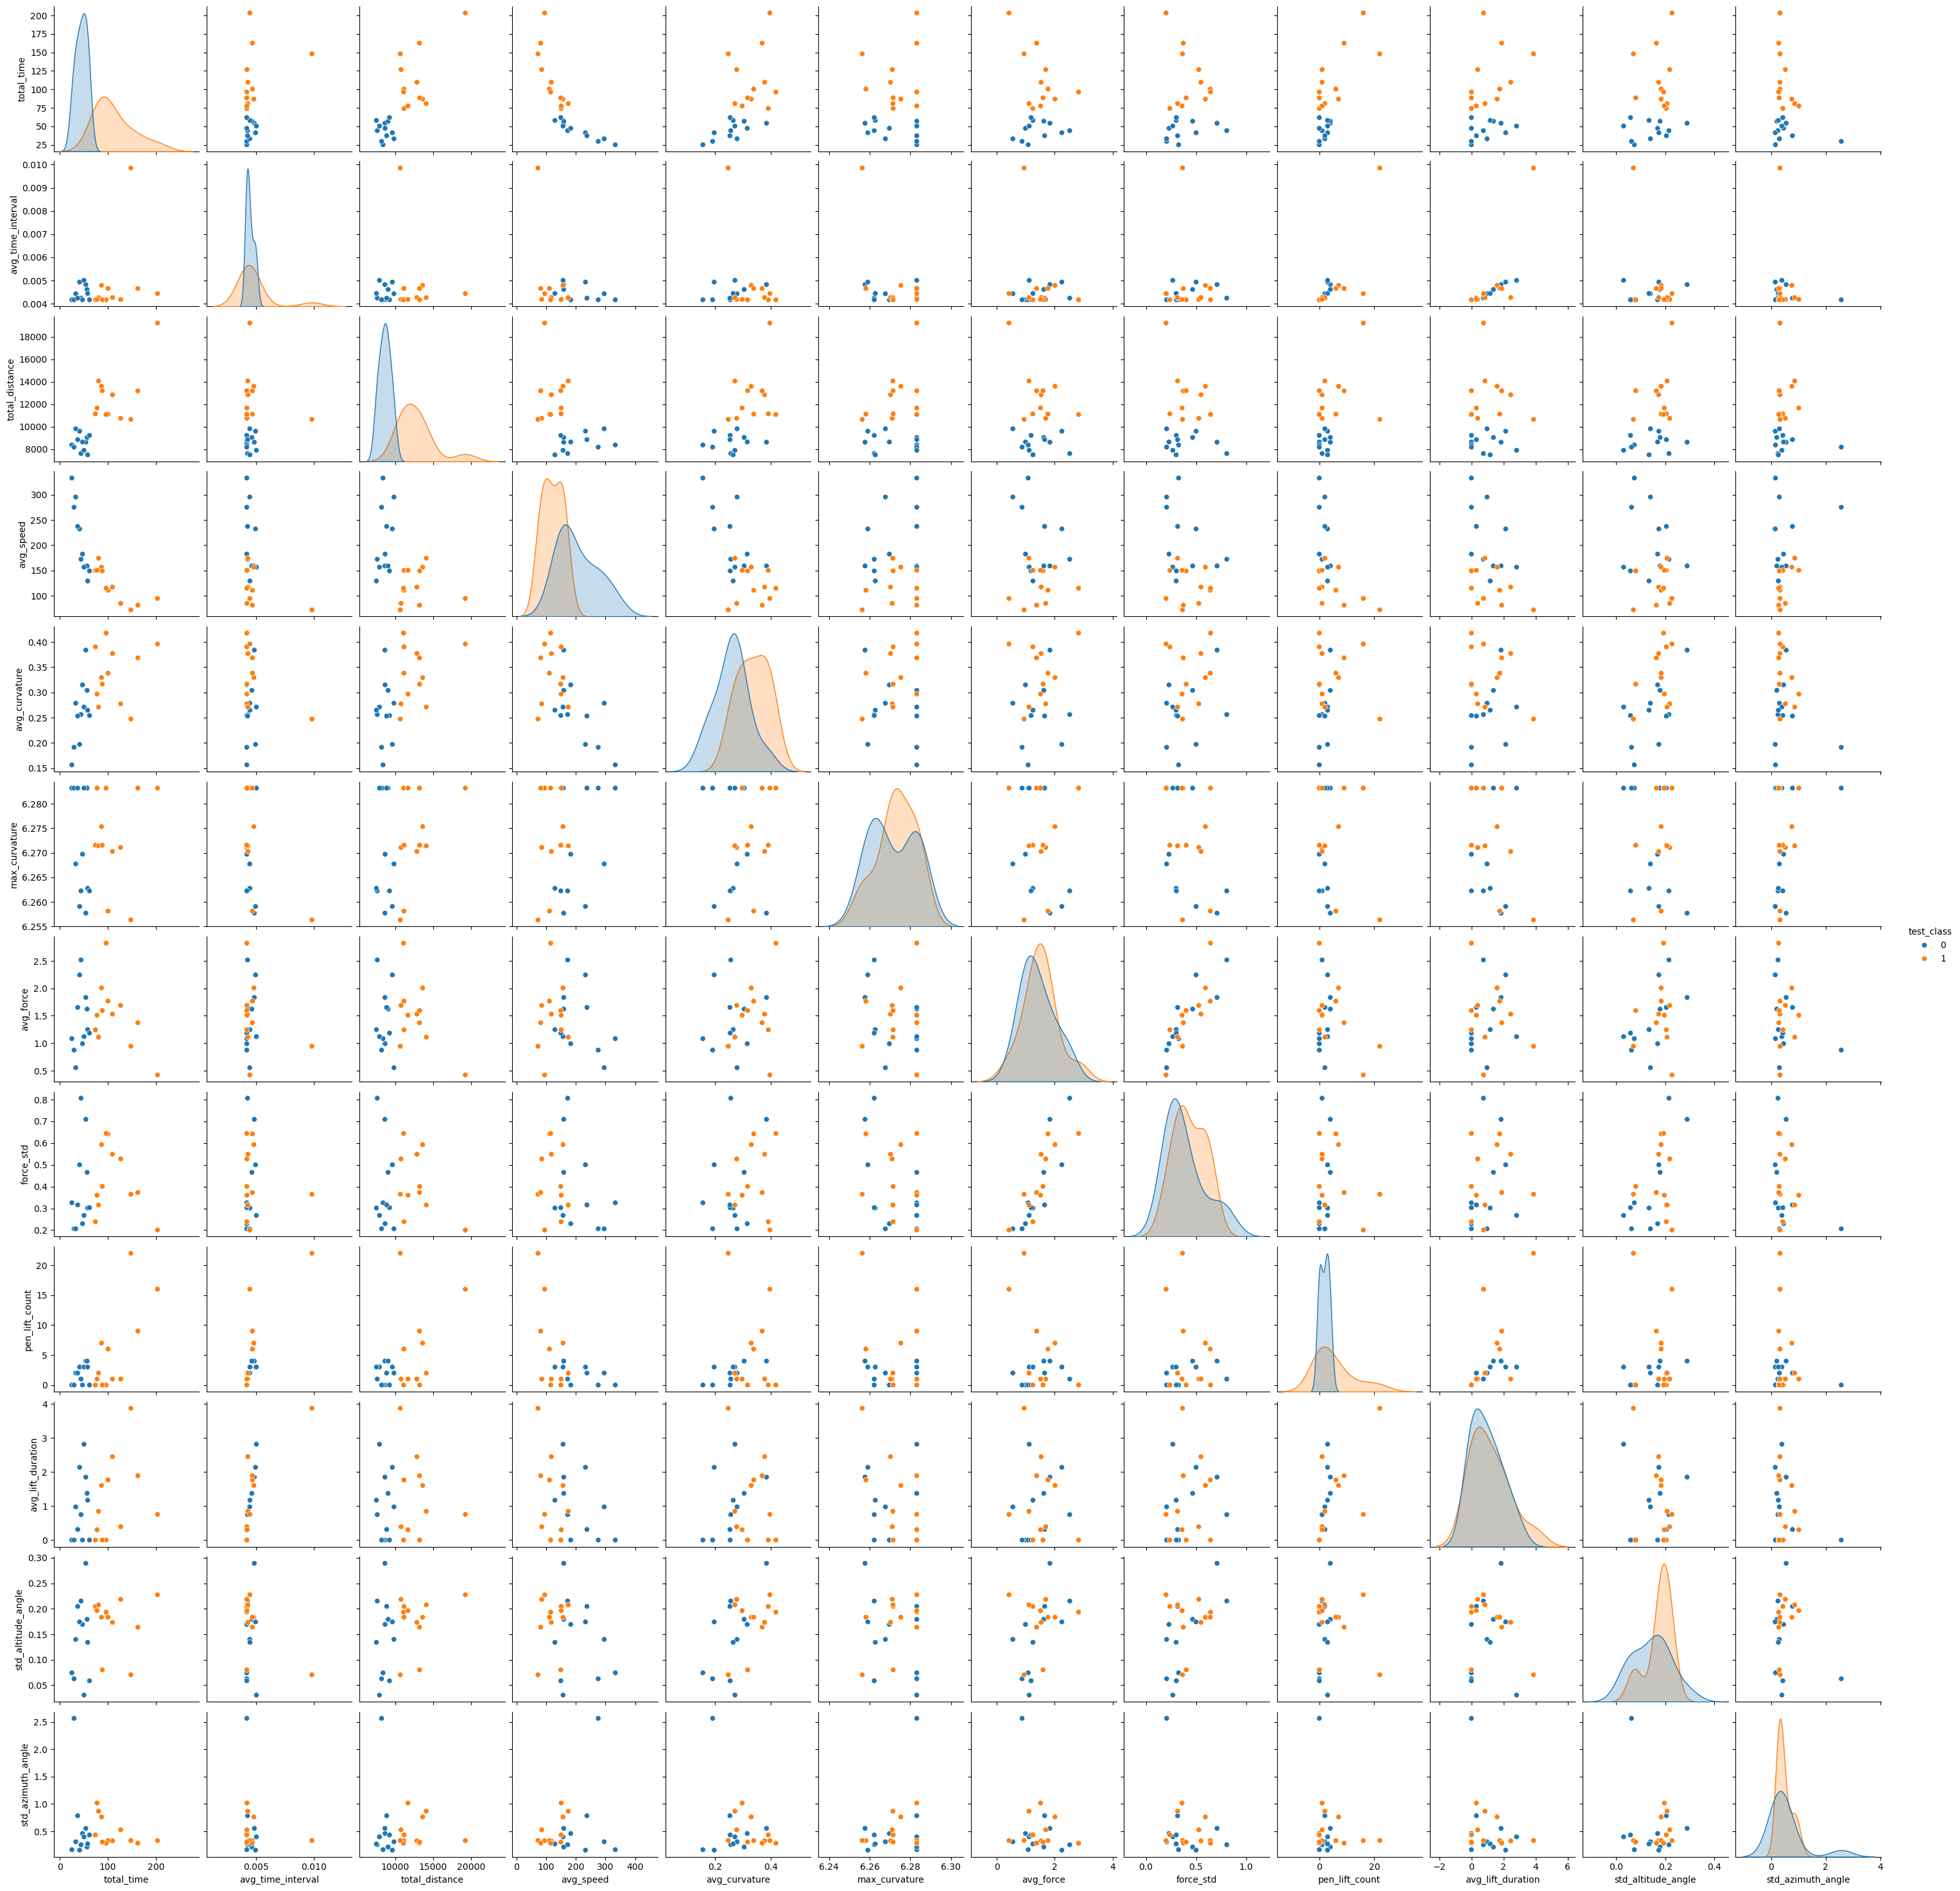

In [114]:

# Pairplot

sns.pairplot(feature_df, hue='test_class')
plt.show()